### About 
This notebooks trains a ocean detector with MobileNet + UNet structure on the full MODD2 dataset 

- Image Augmentation implemented
- Pipeline implemented, with proper train-val-test splits
- MODD2 Evaluation method implemented


    Dataset   : 'large.zip' 
    train set : 10412 images (drawn from 26 video sequences)
    test set  : 1292  images (drawn from 2 video sequences)

    X: ? x 128 x 128 x 3 .png files
    y: ? x 128 x 128     .png files 

### Imports & Installs 

tfds-nightly for upsampling layers


In [1]:
# Install tfds-nightly for upsampling layer
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
# Install tfa for transformations
!pip install -q -U tensorflow-addons
                                     

     |████████████████████████████████| 3.9MB 19.6MB/s 
     |████████████████████████████████| 706kB 23.4MB/s 


In [2]:
import os
import re
import random
import time
import math

import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np 
import matplotlib.pyplot as plt

from PIL import Image as pimage 
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load data from google drive

In [3]:
if 'data' not in os.listdir():
  !cp "/content/drive/My Drive/project_online/dataset/large.zip" .
  !unzip -q 'large.zip' -d data
  !rm 'large.zip'

```
data
  - annotations
    - train (10412)
    - test (1292)
  - images
    - train
    - test

Image names: 
  01_001.png 
  128 x 128 x 3
Annotation image names: 
  01_001_label.png
  128 x 128 x 1 (background-pixel = 0, sea-pixel = 1)
```



In [4]:
data_dir = os.path.join(os.getcwd(), 'data/')
images_path = os.path.join(os.getcwd(), 'data/images/')
labels_path = os.path.join(os.getcwd(), 'data/annotations/')

TRAIN_IMG_DIR = images_path + 'train/'
TEST_IMG_DIR = images_path + 'test/'

TRAIN_LABEL_DIR = labels_path + 'train/'
TEST_LABEL_DIR = labels_path + 'test/'

train_image_count, test_image_count = len(os.listdir(TRAIN_IMG_DIR)), len(os.listdir(TEST_IMG_DIR))
print('train: {}, test: {}'.format(train_image_count, test_image_count))

train: 10411, test: 1292


In [5]:
IMG_SIZE = 128
BATCH_SIZE = 64
N_CLASSES = 2
TRAIN_VAL_RATIO = 0.8

# For reproducible result 
SEED = 123

In [6]:
def get_globs(val_video_numbers):
  '''
  Returns two list of globs to pass in Dataset.list_files() reprenting train and val image formats

  Args:
  ----------
  val_video_number: list of integers

  Returns:
  ----------
  out_train, out_val: (list, list)
    two lists of globs in the format of:
    TRAIN_IMG_DIR + "folder_number_*.png"
  '''

  nums = list(range(1, 27))
  nums_train = [i for i in nums if i not in val_video_numbers]

  out_val, out_train = [], []
  for n in val_video_numbers:
    out_val.append(TRAIN_IMG_DIR + "{:02}_*.png".format(n))
  for n in nums_train:
    out_train.append(TRAIN_IMG_DIR + "{:02}_*.png".format(n))
  return out_train, out_val

In [7]:
def parse_image(img_path: str) -> dict:
    '''
    For a given image path, loads and returns a dictionary of the image and its mask 

    Args
    ----------
    img_path : str
        Image filename pattern (glob)
        (Mask location is found using regex)

    Returns
    ----------
    dict {'image': tensor (128 x 128 x 3), 'mask': tensor (128 x 128 x 3)}
        Dictionary mapping an image and its annotation.
    '''
    
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)
    image = tf.image.convert_image_dtype(image, tf.dtypes.uint8)

    # For one Image path:
    # .../data/images/train/01_001.png
    # Its corresponding annotation path is:
    # .../data/annotations/train/01_001_label.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, ".png", "_label.png")

    mask = tf.io.read_file(mask_path) 
    # for some reason pixel value of 255 is not registered when dtype is uint8
    # the annotation format will be changed in the future
    mask = tf.image.decode_png(mask, channels=1, dtype=tf.dtypes.uint16)
    mask = tf.where(mask == 255, np.dtype('uint16').type(2), mask)
    mask = tf.where(mask == 1, np.dtype('uint16').type(1), mask)

    return {'image': image, 'mask': mask}

In [8]:
# Get list of globs for train-test split
train_globs, val_globs = get_globs([5, 16])

# Get list of file names for train, val, and test
train_ds = tf.data.Dataset.list_files(train_globs, shuffle=False)
val_ds = tf.data.Dataset.list_files(val_globs, shuffle=False)
test_ds = tf.data.Dataset.list_files(TEST_IMG_DIR + '*.png', shuffle=False)

# Get length of each dataset
TRAINSET_SIZE = tf.data.experimental.cardinality(train_ds).numpy()
VALSET_SIZE = tf.data.experimental.cardinality(val_ds).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_ds).numpy()
print(f'Train: {TRAINSET_SIZE}, Val: {VALSET_SIZE}, Test, {TEST_SIZE}')

Train: 9039, Val: 1372, Test, 1292


In [9]:
train_ds = train_ds.map(parse_image)
val_ds = val_ds.map(parse_image)
test_ds = test_ds.map(parse_image)

### Transformation setup 

In [10]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    '''
    Rescale the pixel values of the images from [0, 255] to [0, 1]

    Args
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [128,128,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [128,128,1].

    Returns
    ----------
    tuple
        Normalized image and its annotation.
    '''

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask


In [11]:
def load_image_train(datapoint: dict) -> tuple:
    '''
    Apply some transformations to an input dictionary
    containing an image and its annotation.

    Note: should be applying to training set only

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A modified image and its annotation.
    '''

    width = IMG_SIZE
    height = IMG_SIZE

    input_image = datapoint['image']
    input_mask = datapoint['mask']

    # # Flip
    # if tf.random.uniform(()) > 0.5:
    #   input_image = tf.image.flip_left_right(input_image)
    #   input_mask = tf.image.flip_left_right(input_mask)
    
    # # Hue
    # if tf.random.uniform(()) > 0.2:
    #   input_image = tf.image.random_hue(input_image, 0.1)
    #   input_image = tf.image.random_saturation(input_image, 0.8, 1.2)
    #   input_image = tf.image.random_contrast(input_image, 0.8, 1.2)
    #   input_image = tf.image.random_brightness(input_image, 0.2)

    # # Rotation
    # if tf.random.uniform(()) > 0.5:
    #   alpha = tf.random.uniform(()) * math.pi/8 - math.pi/4
    #   input_image = tfa.image.rotate(tf.cast(input_image, dtype=tf.int32), alpha)
    #   input_mask = tfa.image.rotate(tf.cast(input_mask, dtype=tf.int32), alpha)
    #   input_image = tf.cast(input_image, dtype=tf.uint8)
    #   input_mask = tf.cast(input_mask, dtype=tf.uint16)

    # # Scaling
    # if tf.random.uniform(()) > 0.2:
    #   crop_width = tf.random.uniform(shape=(), minval=math.floor(0.6 * width), maxval=math.floor(0.9 * width), dtype = tf.int32)
    #   crop_height = tf.random.uniform(shape=(), minval=math.floor(0.6 * height), maxval=math.floor(0.9 * height), dtype = tf.int32)

    #   offset_x = tf.random.uniform(shape=(), minval=0, maxval=width - crop_width, dtype = tf.int32)
    #   offset_y = tf.random.uniform(shape=(), minval=0, maxval=height - crop_height, dtype = tf.int32)

    #   input_image = tf.image.crop_to_bounding_box(input_image, offset_y, offset_x, crop_height, crop_width)
    #   input_mask = tf.image.crop_to_bounding_box(input_mask, offset_y, offset_x, crop_height, crop_width)

    # Resize
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    # Normalize & clip
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.clip_by_value(input_image, clip_value_min=0., clip_value_max=1.)

    return input_image, input_mask

In [12]:
def load_image_test(datapoint: dict) -> tuple:
    '''
    Normalize and resize a test image and its annotation, no augmentation

    Note: 
      Applies to both validation and testing set

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    '''

    # input_image = datapoint['image']
    # input_mask = datapoint['mask']

    # Resize
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['mask'], (IMG_SIZE, IMG_SIZE))

    # Normalize
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [13]:
train_ds = train_ds.map(load_image_train, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image_test, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_image_test, num_parallel_calls=AUTOTUNE)

In [14]:
def configure_ds(ds):
  '''
  configures dataset to optimize performace 

  Note: 
    Applies to both train and val (not test set)
  '''
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size=BATCH_SIZE)
  ds = ds.repeat()
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [15]:
train_ds = configure_ds(train_ds)
val_ds = configure_ds(val_ds)

# Test set doesn't need to be shuffled
test_ds = test_ds.batch(batch_size = BATCH_SIZE)

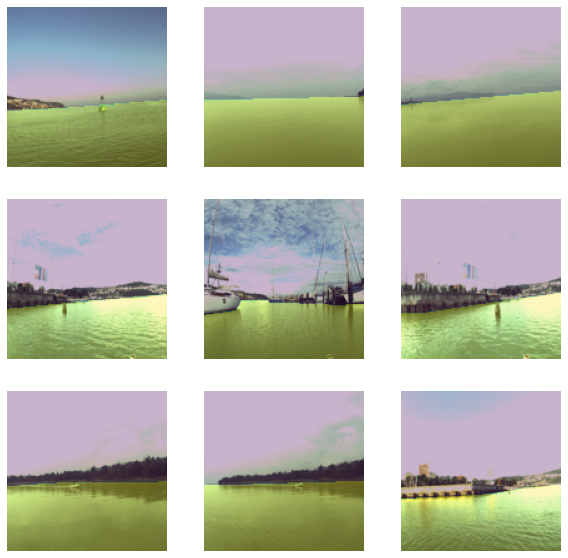

In [16]:
### Display images

image_batch, mask_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  image = image_batch[i]
  mask = mask_batch[i]
  plt.imshow(image)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(mask), alpha=0.3)
  plt.axis("off")

(-0.5, 127.5, 127.5, -0.5)

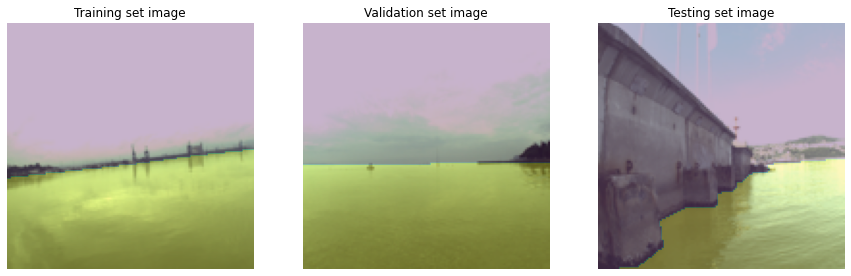

In [17]:
image_batch, mask_batch = next(iter(train_ds))
image_batch1, mask_batch1 = next(iter(val_ds))

for image_batch2, mask_batch2 in test_ds.take(10):
  pass

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Training set image')
plt.imshow(image_batch[0])
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_batch[0]), alpha=0.3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Validation set image')
plt.imshow(image_batch1[0])
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_batch1[0]), alpha=0.3)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Testing set image')
plt.imshow(image_batch2[0])
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_batch2[0]), alpha=0.3)
plt.axis('off')


In [18]:
mask_batch[0][80]

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
 

### Model Definition

In [29]:
# Encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Extract the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64 x 64 x 96
    'block_3_expand_relu',   # 32 x 32 x 144
    'block_6_expand_relu',   # 16 x 16 x 192
    'block_13_expand_relu',  # 8  x 8  x 576
    'block_16_project',      # 4  x 4  x 320
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [30]:
# Decoder
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [31]:
def unet_model(output_channels):
  ''' Instantiate a new instance of UNet Model '''
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Visualisation functions

In [22]:
def create_mask(pred_mask):
  ''' Finds top prediction mask and returns it'''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [125]:
import matplotlib.colors as colors

custom_cmap = colors.ListedColormap(['#084081','#7ACBC4','#F7FCF0', 'black'])
boundaries = np.array([-1, 0, 1, 2, 5])+0.01
norm = colors.BoundaryNorm(boundaries, custom_cmap.N)

def display(display_list, merge = False, withTitle=False):
  '''
  Takes an array of images and plots them

  Args
  ----------
  display_list: list
    expecting [input, true mask, predicted mask]

  Returns
  ----------
  None, graph is displayed
  '''
  if not merge:
    plt.figure(figsize=(15, 15))
    

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      if (withTitle):
        plt.title(title[i], fontsize=15)
      displayed_image = display_list[i]
      if (display_list[i].shape[-1] == 1):
        displayed_image = display_list[i].numpy().squeeze()
      plt.imshow(displayed_image, cmap=custom_cmap, norm=norm)
      plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.05,  hspace=0.05)
    plt.show()

  elif merge == True:
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[1]), alpha = 0.5)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[2]), alpha = 0.5)
    plt.axis('off')

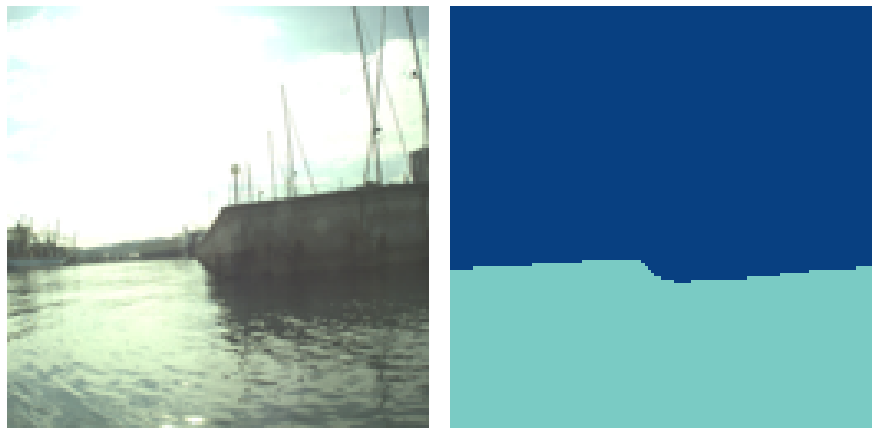

In [126]:
def show_predictions(dataset=None, num=1, show_sample=False, merge=False):
  '''
  For a given dataset plots one image, its true mask, and predicted mask

  Args
  ----------
  dataset (optional): tf.dataset object, defaults first image in testing set
  num (optional): int
  sample (optional): bool: if True, display prediction for sample image

  Returns
  ----------
  Nothing, graph will be displayed

  '''
  batches = num//BATCH_SIZE + 1
  remainder = num%BATCH_SIZE
  if show_sample:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], merge=merge) 
    return
  if dataset:
    for image, mask in dataset.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)
  else:
    for image, mask in test_ds.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)

for images, masks in test_ds.take(7):
  sample_image, sample_mask = images[0], masks[0] 

display([sample_image, sample_mask])

### Training

In [92]:
model = unet_model(output_channels=N_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

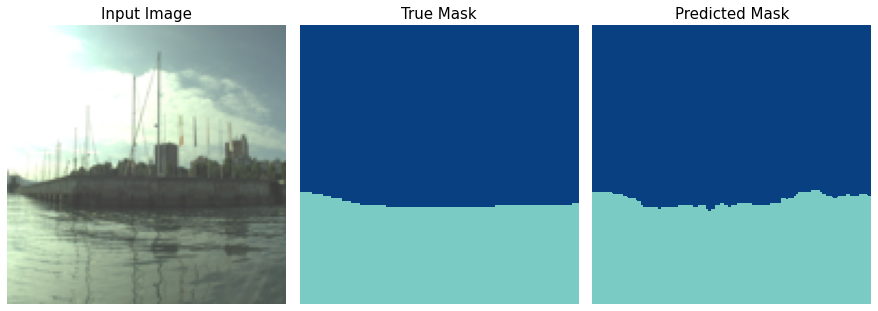

In [124]:
show_predictions(dataset=test_ds, num=300)

In [95]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(show_sample=True)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [96]:
EPOCHS = 30
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds)

Epoch 1/30
141/141 [==============================] - 30s 176ms/step - loss: 0.1930 - accuracy: 0.9182 - val_loss: 0.0642 - val_accuracy: 0.9800
Epoch 2/30
141/141 [==============================] - 22s 156ms/step - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.0314 - val_accuracy: 0.9897
Epoch 3/30
141/141 [==============================] - 22s 153ms/step - loss: 0.0112 - accuracy: 0.9959 - val_loss: 0.0226 - val_accuracy: 0.9920
Epoch 4/30
141/141 [==============================] - 22s 153ms/step - loss: 0.0096 - accuracy: 0.9964 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 5/30
141/141 [==============================] - 22s 154ms/step - loss: 0.0083 - accuracy: 0.9968 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 6/30
141/141 [==============================] - 22s 154ms/step - loss: 0.0074 - accuracy: 0.9971 - val_loss: 0.0233 - val_accuracy: 0.9923
Epoch 7/30
141/141 [==============================] - 22s 154ms/step - loss: 0.0069 - accuracy: 0.9972 - val_loss: 0.0238 - val_ac

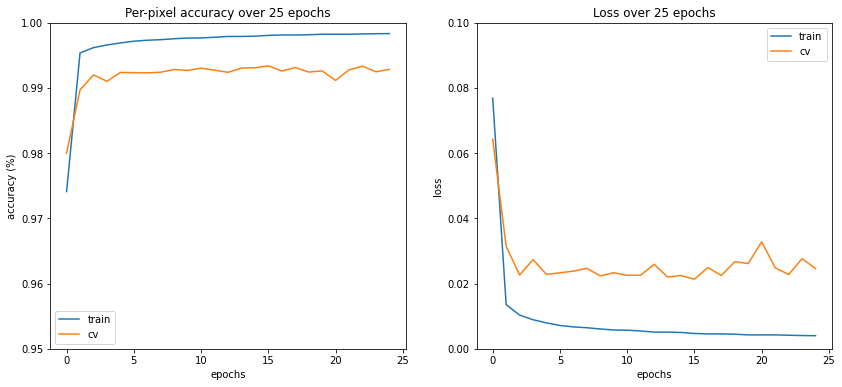

In [140]:
def show_result_graphs(history):
  plt.figure(figsize=(14, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history['accuracy'][:25], label='train')
  plt.plot(history['val_accuracy'][:25], label='cv')
  plt.title(f'Per-pixel accuracy over {25} epochs')
  plt.legend()
  plt.ylabel('accuracy (%)')
  plt.xlabel('epochs')
  plt.ylim(0.95, 1)


  plt.subplot(1, 2, 2)
  plt.plot(history['loss'][:25], label='train')
  plt.plot(history['val_loss'][:25], label='cv')
  plt.title(f'Loss over {25} epochs')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.1)
  plt.show()

show_result_graphs(model_history.history)


In [141]:
def MODD2_shoreline_eval_single_image(gt_mask, pred_mask):

  '''
  Calculates the RMSE of horizon detection for a single image

  Args:
  ---------
  gt_mask: numpy.array (128, 128, 1)
  pred_mask: numpy.array (128, 128, 1)

  Returns:
  --------
  rmse: int
    (normalized) root mean square error of a single image
  '''

  HEIGHT = len(gt_mask)
  WIDTH = len(gt_mask[0, :])
  gt_len = 0

  diffs = np.empty(WIDTH)
  for i in range(WIDTH):
    # print(gt_mask[:, i])
    # print(pred_mask[:, i])
    for j, val in enumerate(gt_mask[:, i]):
      if val > 0:
        gt_len += 1
        break
    for k, val in enumerate(pred_mask[:, i]):
      if val > 0:
        break
    # if no detection along column, assume detection is at bottom of the image
    diffs[i] = abs(j - k)/HEIGHT
    # overflow occurs because of np division, shouldn't affect performance
    rmse = np.sqrt((sum(diffs)**2))/gt_len
  return rmse

tic = time.perf_counter()
gt_mask = sample_mask.numpy()
pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...])).numpy()
toc = time.perf_counter()
print(f"preparing: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
MODD2_shoreline_eval_single_image(gt_mask, pred_mask)
toc = time.perf_counter()
print(f"RMSE: {toc - tic:0.4f} seconds")

preparing: 0.0502 seconds
RMSE: 0.0252 seconds


In [142]:
def MODD2_shoreline_eval(ds='test'):
  '''
  Returns score for the MODD2 evaluation of shoreline

  From MODD2 github page:
    For each pixel column in the full-sized image, a distance between water edge, 
    as given by the ground truth and as determined by the algorithm, is calculated. 
    These values are summarised into a single value by averaging across all 
    columns, frames and sequences.

  Args: 
  ----------
  ds: tf.dataset
    dataset object (either train_ds, val_ds, or test_ds)

  Returns:
  ----------
  (mean, std): tuple
    the mean and std for difference between prediction and gt
  '''
  if ds == 'test':
    ds_length = TEST_SIZE
    ds = test_ds
  elif ds == 'train':
    ds_length = TRAINSET_SIZE
    ds = train_ds
  elif ds == 'val':
    ds_length = VALSET_SIZE
    ds = val_ds
  else:
    print('Please input valid dataset name (either train, val, or test)')
    raise ValueError()

  num_batches = ds_length // BATCH_SIZE + 1

  # Loop through batches
  RMSEs = []
  for images, labels in tqdm(ds.take(num_batches)):
    preds = model.predict(images)
    # Loop through images within a batch:
    for i, label in enumerate(labels):
      # Have to convert to numpy, iterating through tensor is very slow
      gt_label = label.numpy()
      pred_label = create_mask(preds[i][tf.newaxis, ...]).numpy()

      RMSE = MODD2_shoreline_eval_single_image(gt_label, pred_label)
      RMSEs.append(RMSE)
  return RMSEs

In [ ]:
# Calculate RMSEs
RMSEs_test, RMSEs_val, RMSEs_train = 0, 0, 0

RMSEs_test = MODD2_shoreline_eval()

mean = np.mean(RMSEs_test)
std = np.std(RMSEs_test)
print(mean, std)
# 0.047273679830566205 0.07390127589649333

100%|██████████| 21/21 [00:38<00:00,  1.85s/it]

0.04735500425637365 0.07296493484403138


In [ ]:
RMSEs_val = MODD2_shoreline_eval('val')

mean = np.mean(RMSEs_val)
std = np.std(RMSEs_val)
print(mean, std)

# 0.0015009606147934678 0.000944358694756475

100%|██████████| 22/22 [00:37<00:00,  1.73s/it]

0.007459634942146501 0.007017931575616689


In [ ]:
RMSEs_train = MODD2_shoreline_eval('train')

mean = np.mean(RMSEs_train)
std = np.std(RMSEs_train)
print(mean, std)
# 0.0014024600744476465 0.00087460573507159

100%|██████████| 142/142 [04:12<00:00,  1.78s/it]

0.0017162972496784766 0.0010941703841260235


### Score Summary


In [ ]:
print('Training set')
print('====================')
print('no images: {}'.format(TRAINSET_SIZE))
print('mean:      {:.3e}'.format(np.mean(RMSEs_train)))
print('std:       {:.3e}'.format(np.std(RMSEs_train)))
print('mean-px:   {:.3} px'.format(np.mean(RMSEs_train) * 384))

print('\nValidation set')
print('====================')
print('no images: {}'.format(VALSET_SIZE))
print('mean:      {:.3e}'.format(np.mean(RMSEs_val)))
print('std:       {:.3e}'.format(np.std(RMSEs_val)))
print('mean-px:   {:.3} px'.format(np.mean(RMSEs_val) * 384))

print('\nTest set')
print('====================')
print('no images: {}'.format(TEST_SIZE))
print('mean:      {:.3e}'.format(np.mean(RMSEs_test)))
print('std:       {:.3e}'.format(np.std(RMSEs_test)))
print('mean-px:   {:.3} px'.format(np.mean(RMSEs_test) * 384))

Training set
no images: 9039
mean:      1.716e-03
std:       1.094e-03
mean-px:   0.659 px

Validation set
no images: 1372
mean:      7.460e-03
std:       7.018e-03
mean-px:   2.86 px

Test set
no images: 1292
mean:      4.736e-02
std:       7.296e-02
mean-px:   18.2 px


In [ ]:
model.evaluate(test_ds, steps = test_image_count/BATCH_SIZE)

20/20 [==============================] - 2s 88ms/step - loss: 0.1713 - accuracy: 0.9577


[0.17128103971481323, 0.9576647281646729]

In [ ]:
# Test images
# 27_128 (reflection)         take(3)
# 27_256 (building)           take(5)
# 27_384 (big wall right)     take(7)
# 27_448 (big wall mid)       take(8)
# 27_512 (big wall left)      take(9)
# --------------------------- (total 671 images)
# 28_33 (standard)            take(12)
# 28_417 (wall mid)           take(18)
# 28_609 (hazy)               take(21)

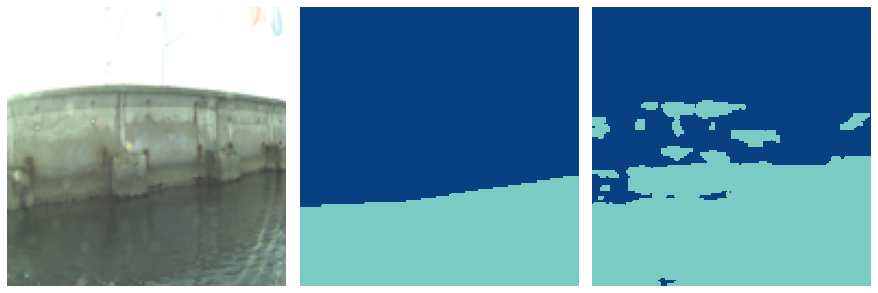

216.34521484375

In [148]:
index = 10

for image, mask in test_ds.take(8):
  display_image, display_mask = image[index], mask[index]

pred_mask = model.predict(display_image[tf.newaxis, ...])
pred_mask = create_mask(pred_mask)
display([display_image, display_mask, pred_mask])

# 5 8 21

MODD2_shoreline_eval_single_image(display_mask.numpy(), pred_mask.numpy()) * 958

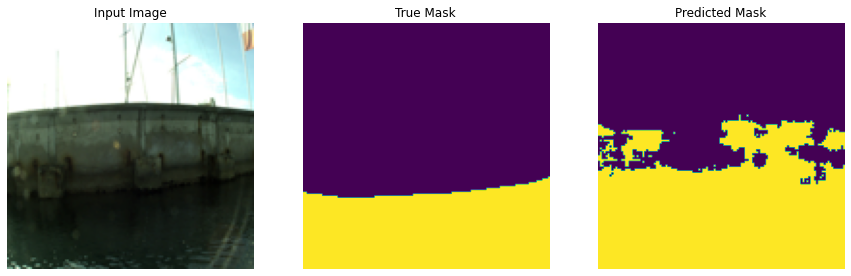


Sample Prediction after epoch 5



### Sources used

Workflow tutorial:
https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/